In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
#hyperparameters
batch_size = 64
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

torch.manual_seed(696)

In [4]:
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [5]:
with open('/kaggle/input/gpt-poems/poems.txt', 'r', encoding='utf-8') as f:
  text = f.read()

print(len(text))
print(text[:500])

30030
Hither hither, love—
‘Tis a shady mead—
Hither, hither, love!
Let us feed and feed!

Hither, hither, sweet—
‘Tis a cowslip bed—
Hither, hither, sweet!
‘Tis with dew bespread!

Hither, hither, dear
By the breath of life,
Hither, hither, dear!—
Be the summer’s wife!

Though one moment’s pleasure
In one moment flies—
Though the passion’s treasure
In one moment dies;—

Yet it has not passed—
Think how near, how near!—
And while it doth last,
Think how dear, how dear!

Hither, hither, hither
Love its


In [6]:
chars = sorted(list(set(text)))
#print(chars)
vocab_size = len(chars)
print(vocab_size)

65


In [7]:
#creating a char level tokenizerrrr
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# what is lambda? -> an anonymous function (i.e., defined without a name)
# that can take any number of arguments but, unlike normal functions,
# evaluates and returns only one expression

In [8]:
#generating train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

In [9]:
#data loading - why? -> to make batches of the data
def get_batch(split):
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) -  block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  #what's torch.stack? -> concatenates a sequence of tensors along a new dimension
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  x,y = x.to(device), y.to(device)
  return x,y

In [10]:
#making of the loss function
@torch.no_grad()
#use of torch.no grad as it doesnt store any gradients that are getting calculated
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

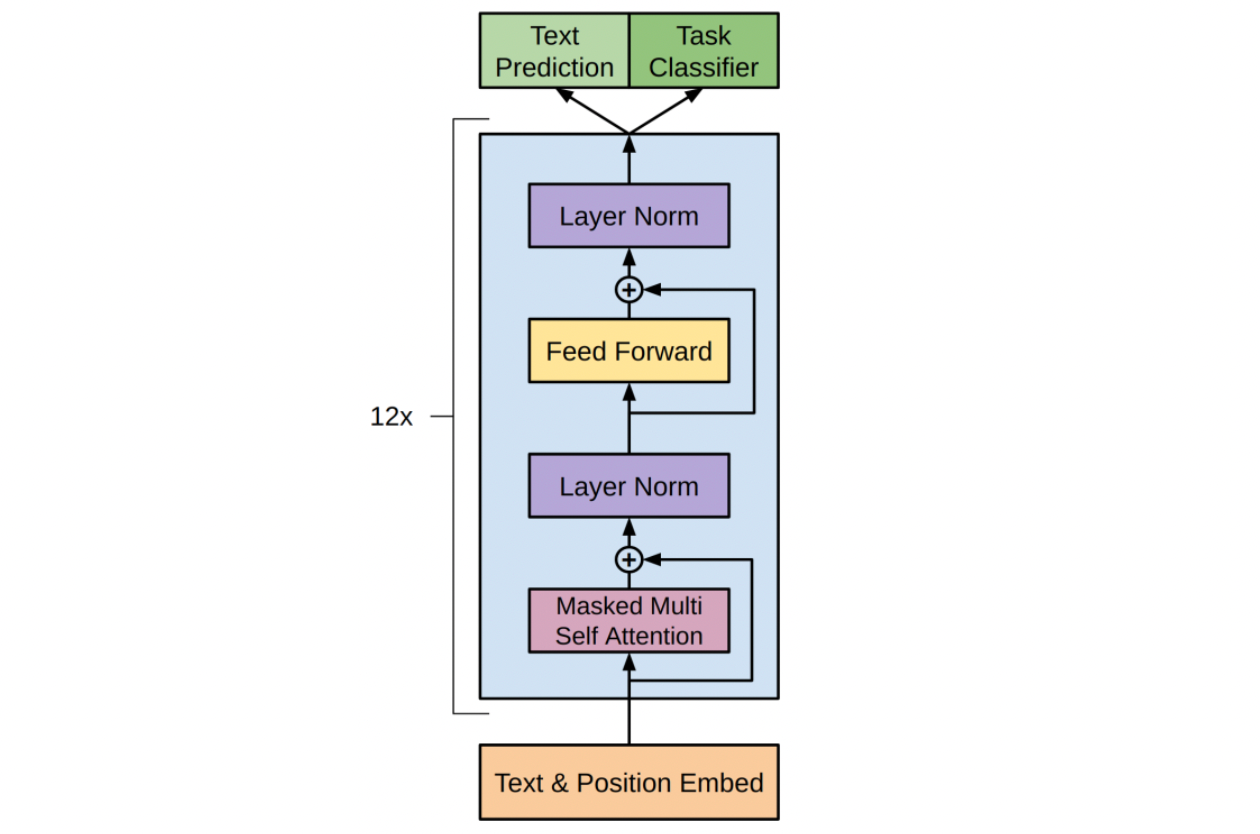
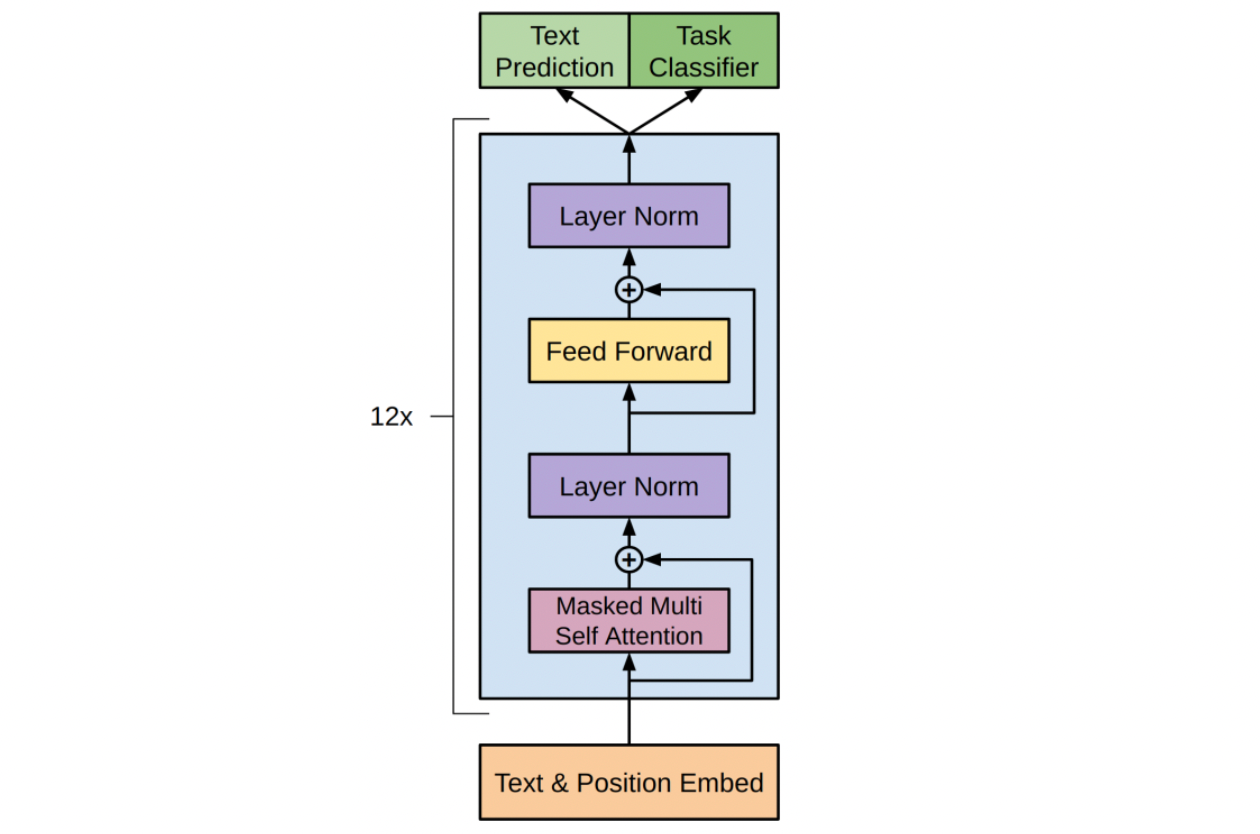

In [11]:
#making of the head for multi head self attention
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        #what the above line does? -> registers a lower triangular matrix as a buffer in the model for efficient use
        self.dropout = nn.Dropout(dropout)
        #why dropout? -> to prevent the model to overfit

    def forward(self, x):
        
        B,T,C = x.shape #batch, time, input channels
        k = self.key(x)  #B,T,hs -> maps the input to key space of dimension of head size
        q = self.query(x) #B,T,hs -> maps the input to query space of dimension of head size
        #compute attention scores -> the same as the one in aiayn paper
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
        #B,T,hs @ (B,T,hs).transpose(-2,-1) -> B,T,hs @ B,hs,T = B,T,T
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) 
        out = wei @ v #B,T,T @ B,T,hs = B,T,hs
        return out

In [12]:
#making of multi head attention
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        #whats modulelist? -> python like list with module features enabled
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [13]:
class FeedFoward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [14]:
class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        #n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [15]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        #each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        #better init
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        #idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [16]:
model = GPTLanguageModel().to(device)

In [17]:
#print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

10.788929 M parameters


In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [19]:
for iter in range(max_iters):

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')

    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.3882, val loss 4.3720
step 500: train loss 1.1046, val loss 2.3979
step 1000: train loss 0.0844, val loss 4.2597
step 1500: train loss 0.0643, val loss 4.7213
step 2000: train loss 0.0575, val loss 4.8252
step 2500: train loss 0.0516, val loss 4.9522
step 3000: train loss 0.0476, val loss 4.9792
step 3500: train loss 0.0469, val loss 5.1009
step 4000: train loss 0.0441, val loss 5.1698
step 4500: train loss 0.0450, val loss 5.1231
step 4999: train loss 0.0418, val loss 5.3072


In [20]:
#generating new texts from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=1000)[0].tolist()))


Ghours was it in Florence; for it drew
Nurture besides, and life, from human fears,
From the fast mouldering head there shut from view:                        
So that the jewel, safely casketed,
Came forth, and in perfumed leafits spread.


O Melancholy, linger here awhile!
O Mercifumsing MusCame, the a paigoldeonce from Hope’s abuskits the seem’d to grow,
And Eaxces tr by in a —
And a lape flooking moments a close,
Warking an Indian from his cloudy hall                                      
With cruel pierce, and bringing him again
Sense of the gnawing fire at heart and brain.


It was a vision.—In the drowsy gloom,
The dull of midnight, at her couch’s foot
Lorenzo stood, and wept: the forest tomb                              
Had marr’d his glossy hair which once could shoot
Lustre into the sun, and put cold doom
Upon his lips, and taken the soft lute
From his lorn voice, and past his loamed ears
Had made a miry channel for his tears.                                    


When the 

In [22]:
poem_heading = "Love Failure"

#encoding the heading into character-level tokens
heading_tokens = torch.tensor(encode(poem_heading), dtype=torch.long, device=device).unsqueeze(0)

#generating a poem based on the heading
generated_tokens = model.generate(heading_tokens, max_new_tokens=1000)

#decoding the generated tokens back to a string
generated_poem = decode(generated_tokens[0].tolist())

print(generated_poem)

Love Failurer’d him Man sat veisad,
Pale Isabella kiss’d it, and low moan’d.
’Twas love.—They pass’d the water                  
Into a forest quiet for the slaughter.


There was Lorenzo slain and buried in,
There in that forest did his great love cease;
Ah! when a soul doth thus its freedom win,
It aches in loneliness—is ill at peace                                 
As the brothers aveid usin shard,
Love never dies, but lives, immortal Lord:
If Love impersonate was ever dead,
Pale Isabella kiss’d it, and low moan’d.
’Twas love; cold,—dead indeed, but not dethroned.                        


In anxious secrecy they toook it home,
And then the prize was all for Isabel:
She calm’d its wild hair with a golden comb,
And all around each eye’s sepulchral cell
Pointed each frime,  ar —Whicher than the songs of Grecian years?—
Withey proud? again we ask alay, for in June:
“To morrow will I bow to my delight,
“To-morrow will I ask my lady’s boon.”—
“O may I never see another night,
“Lorenzo, i